In [1]:
#Imports
import glob
import os
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import random
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
from skimage.io import imread
from skimage.color import rgb2lab, lab2rgb
from scipy import signal
import math
import torch
torch.cuda.empty_cache()
import gc
#del variables
gc.collect()

#Imports
import pickle
import copy
from tqdm import tqdm
import torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim

from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print("Using the GPU!")
else:
    print("WARNING: Could not find GPU! Using CPU only. If you want to enable GPU, please to go Edit > Notebook Settings > Hardware Accelerator and select GPU.")

PyTorch Version:  1.13.1+cu116
Torchvision Version:  0.14.1+cu116


# Upload and Read Dataset

In [2]:
#Upload the data and unzip
!unzip -q '/content/squares_divided.zip'

In [3]:
#Read the dataset
def listdir(path):
    return glob.glob(os.path.join(path, '*'))
train_data = sorted(listdir('/content/squares/train/'))
val_data = sorted(listdir('/content/squares/val/'))
test_data = sorted(listdir('/content/squares/test/'))

In [4]:
#Sanity Checks for Path
print(f'Train Data {train_data}')
print(f'Validation Data {val_data}')
print(f'Test Data {test_data}')

Train Data ['/content/squares/train/a', '/content/squares/train/b', '/content/squares/train/c']
Validation Data ['/content/squares/val/a', '/content/squares/val/b', '/content/squares/val/c']
Test Data ['/content/squares/test/a', '/content/squares/test/b', '/content/squares/test/c']


In [5]:
#Images per class per module

def list_images(data_list):
  '''
  List number of images in each class for each split
  '''
  class_a = listdir(data_list[0])
  class_b = listdir(data_list[1])
  class_c = listdir(data_list[2])
  return class_a, class_b, class_c

class_a_train_images, class_b_train_images, class_c_train_images = list_images(train_data)
class_a_val_images, class_b_val_images, class_c_val_images = list_images(val_data)
class_a_test_images, class_b_test_images, class_c_test_images = list_images(test_data)

print(f'Training Images for Class A {len(class_a_train_images)}')
print(f'Training Images for Class B {len(class_b_train_images)}')
print(f'Training Images for Class C {len(class_c_train_images)}')
print()

print(f'Validation Images for Class A {len(class_a_val_images)}')
print(f'Validation Images for Class B {len(class_b_val_images)}')
print(f'Validation Images for Class C {len(class_c_val_images)}')
print()

print(f'Test Images for Class A {len(class_a_test_images)}')
print(f'Test Images for Class B {len(class_b_test_images)}')
print(f'Test Images for Class C {len(class_c_test_images)}')
print()

Training Images for Class A 500
Training Images for Class B 500
Training Images for Class C 500

Validation Images for Class A 279
Validation Images for Class B 250
Validation Images for Class C 275

Test Images for Class A 221
Test Images for Class B 250
Test Images for Class C 225



## Data Exploration

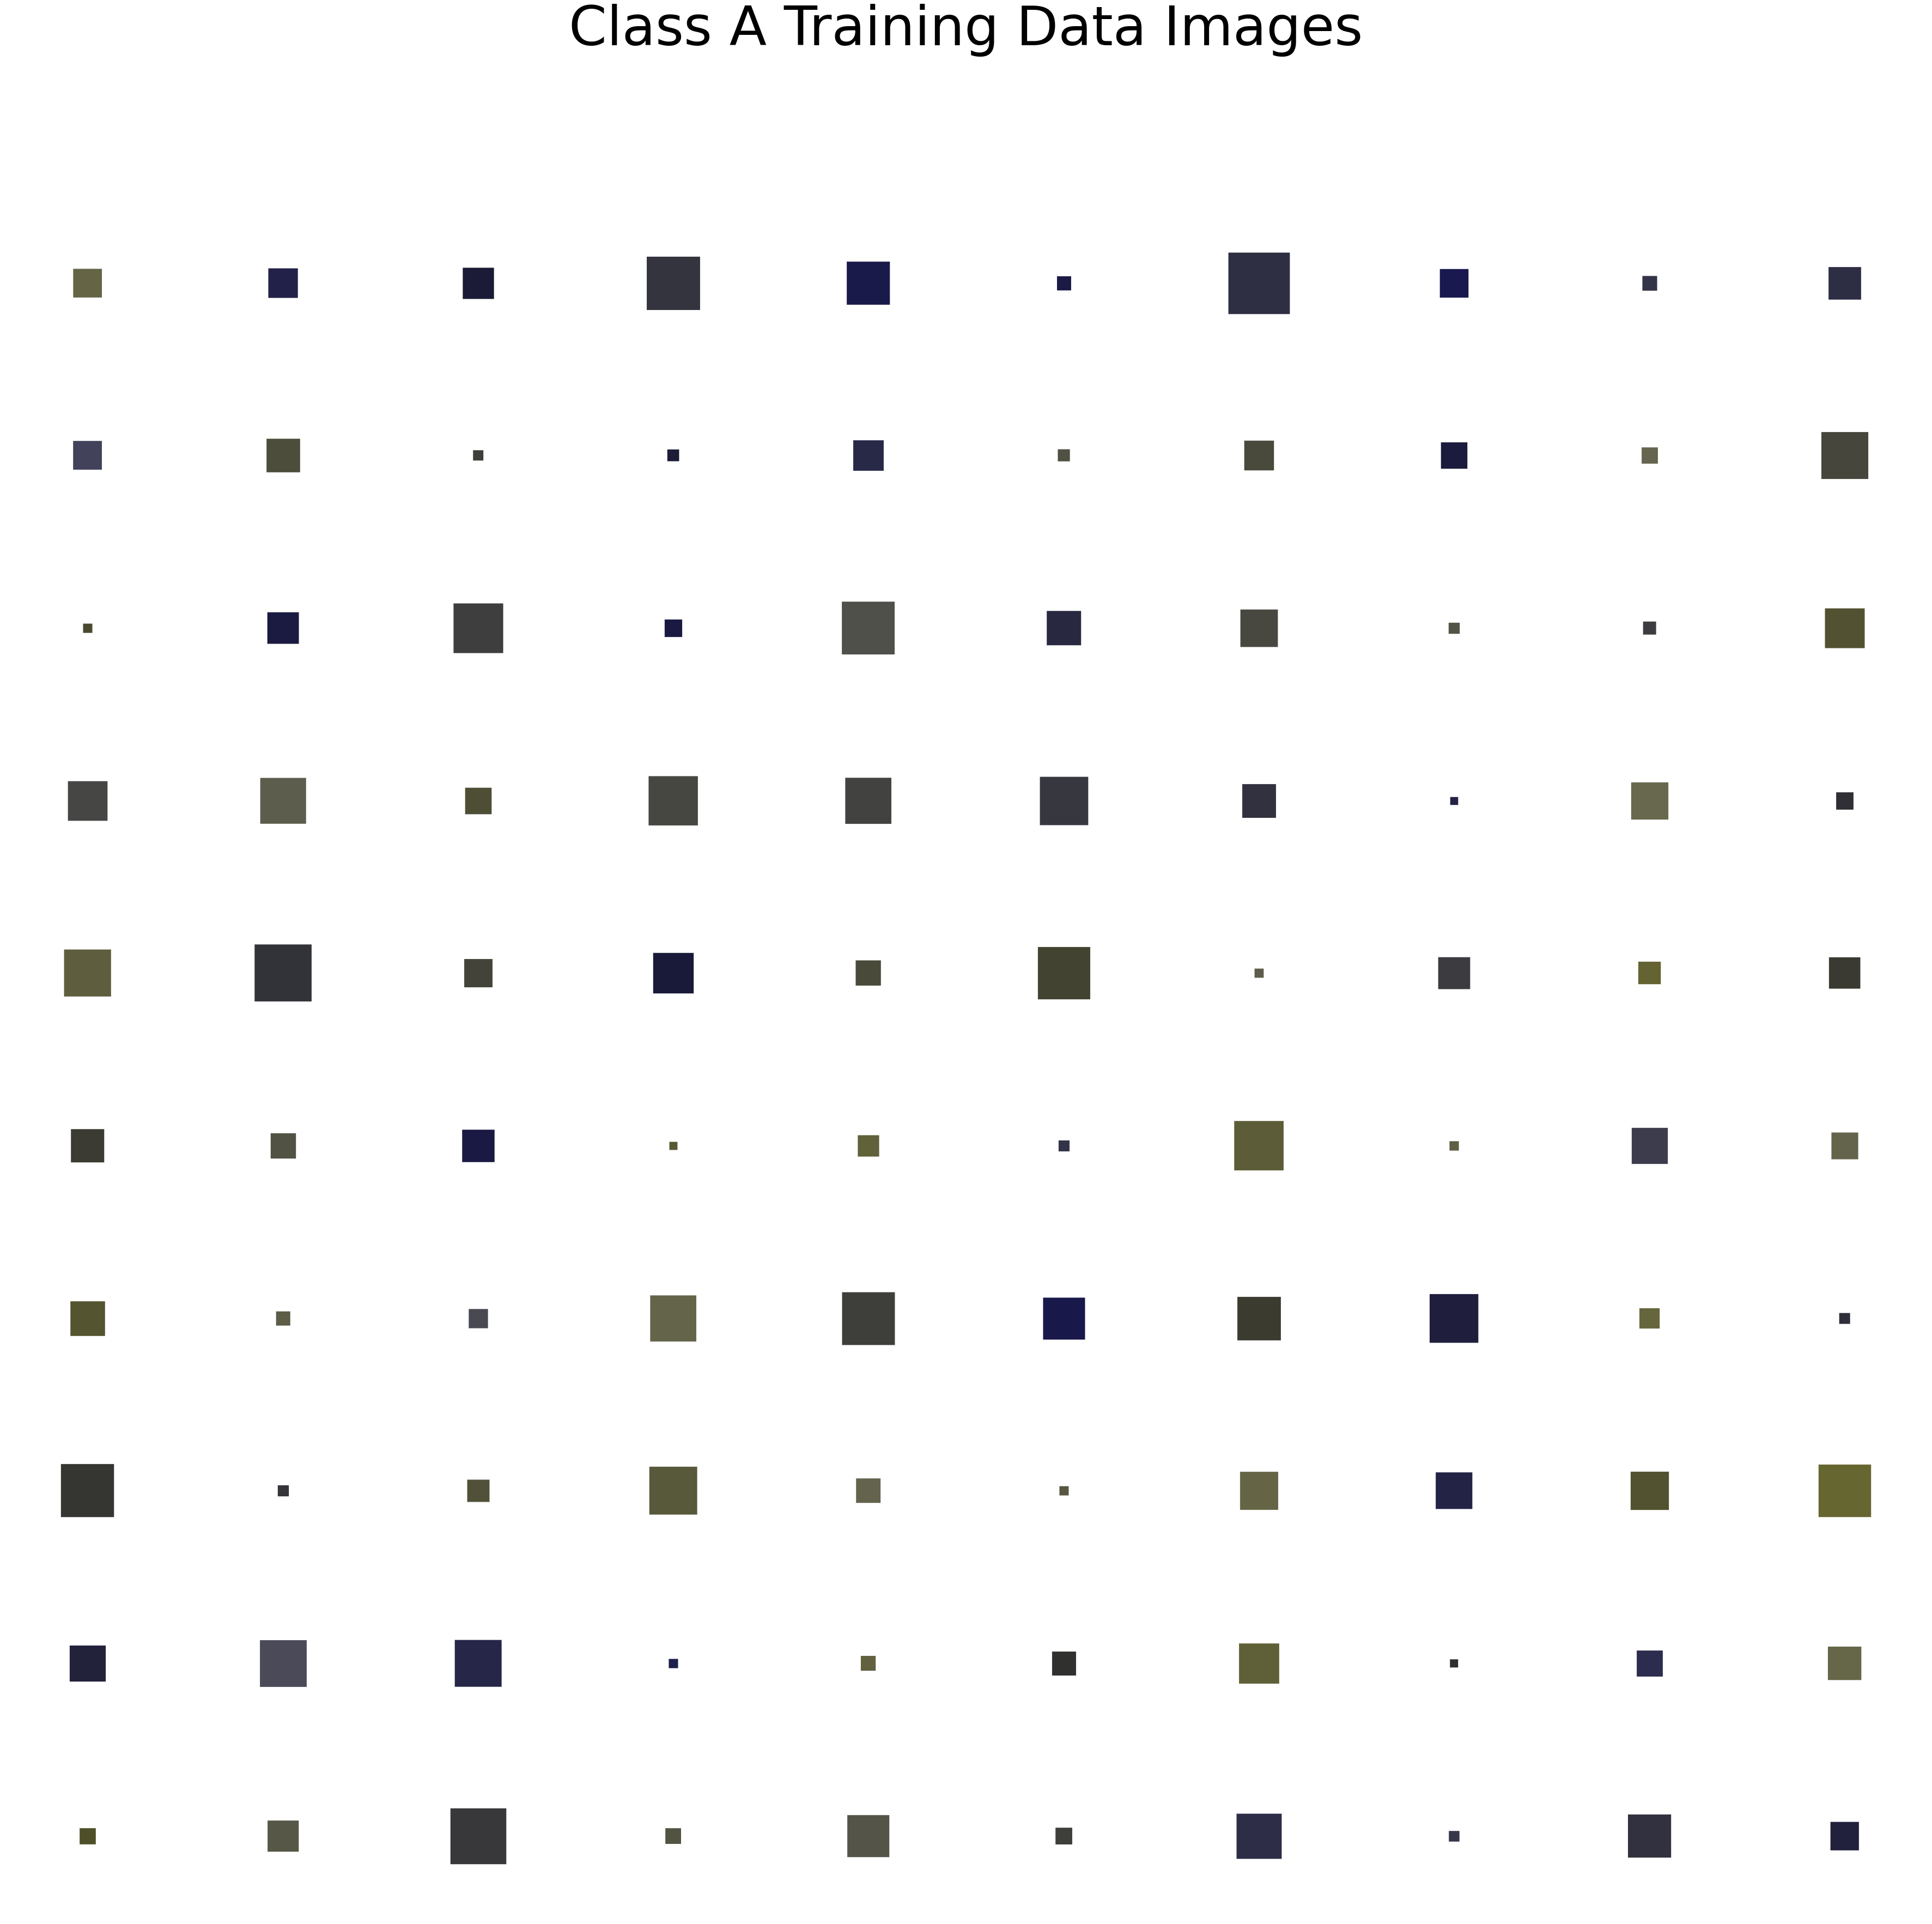

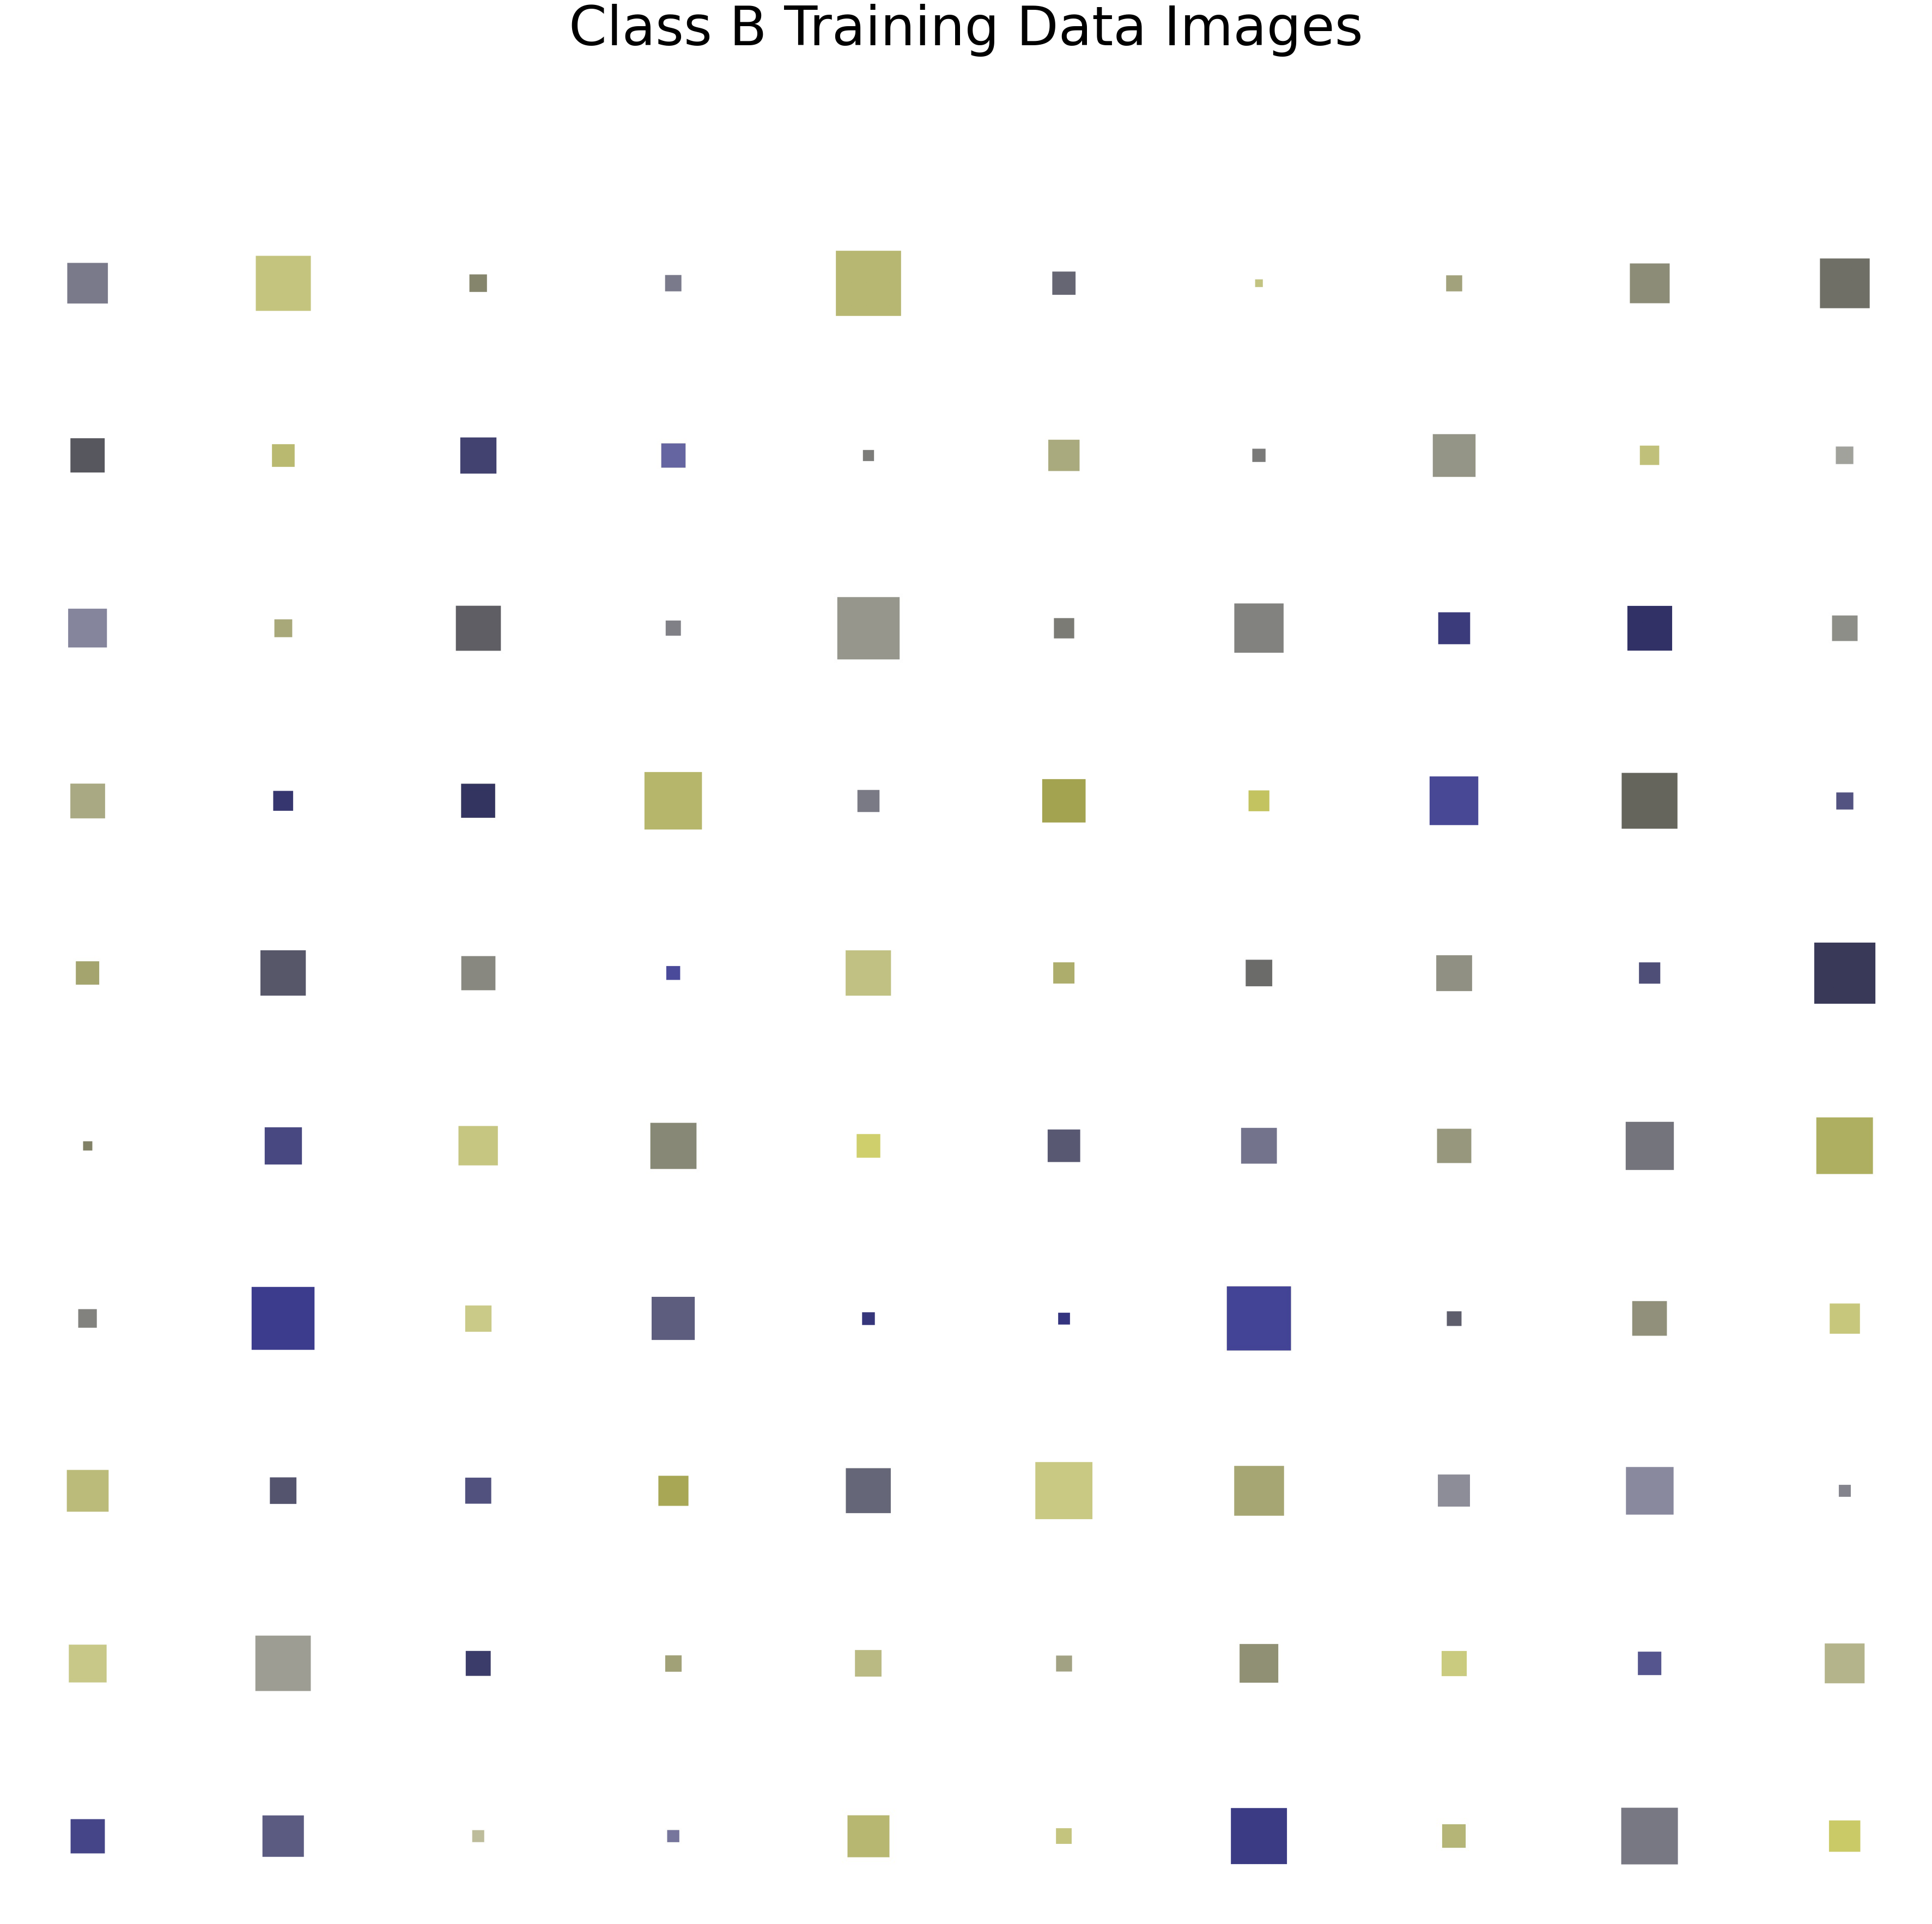

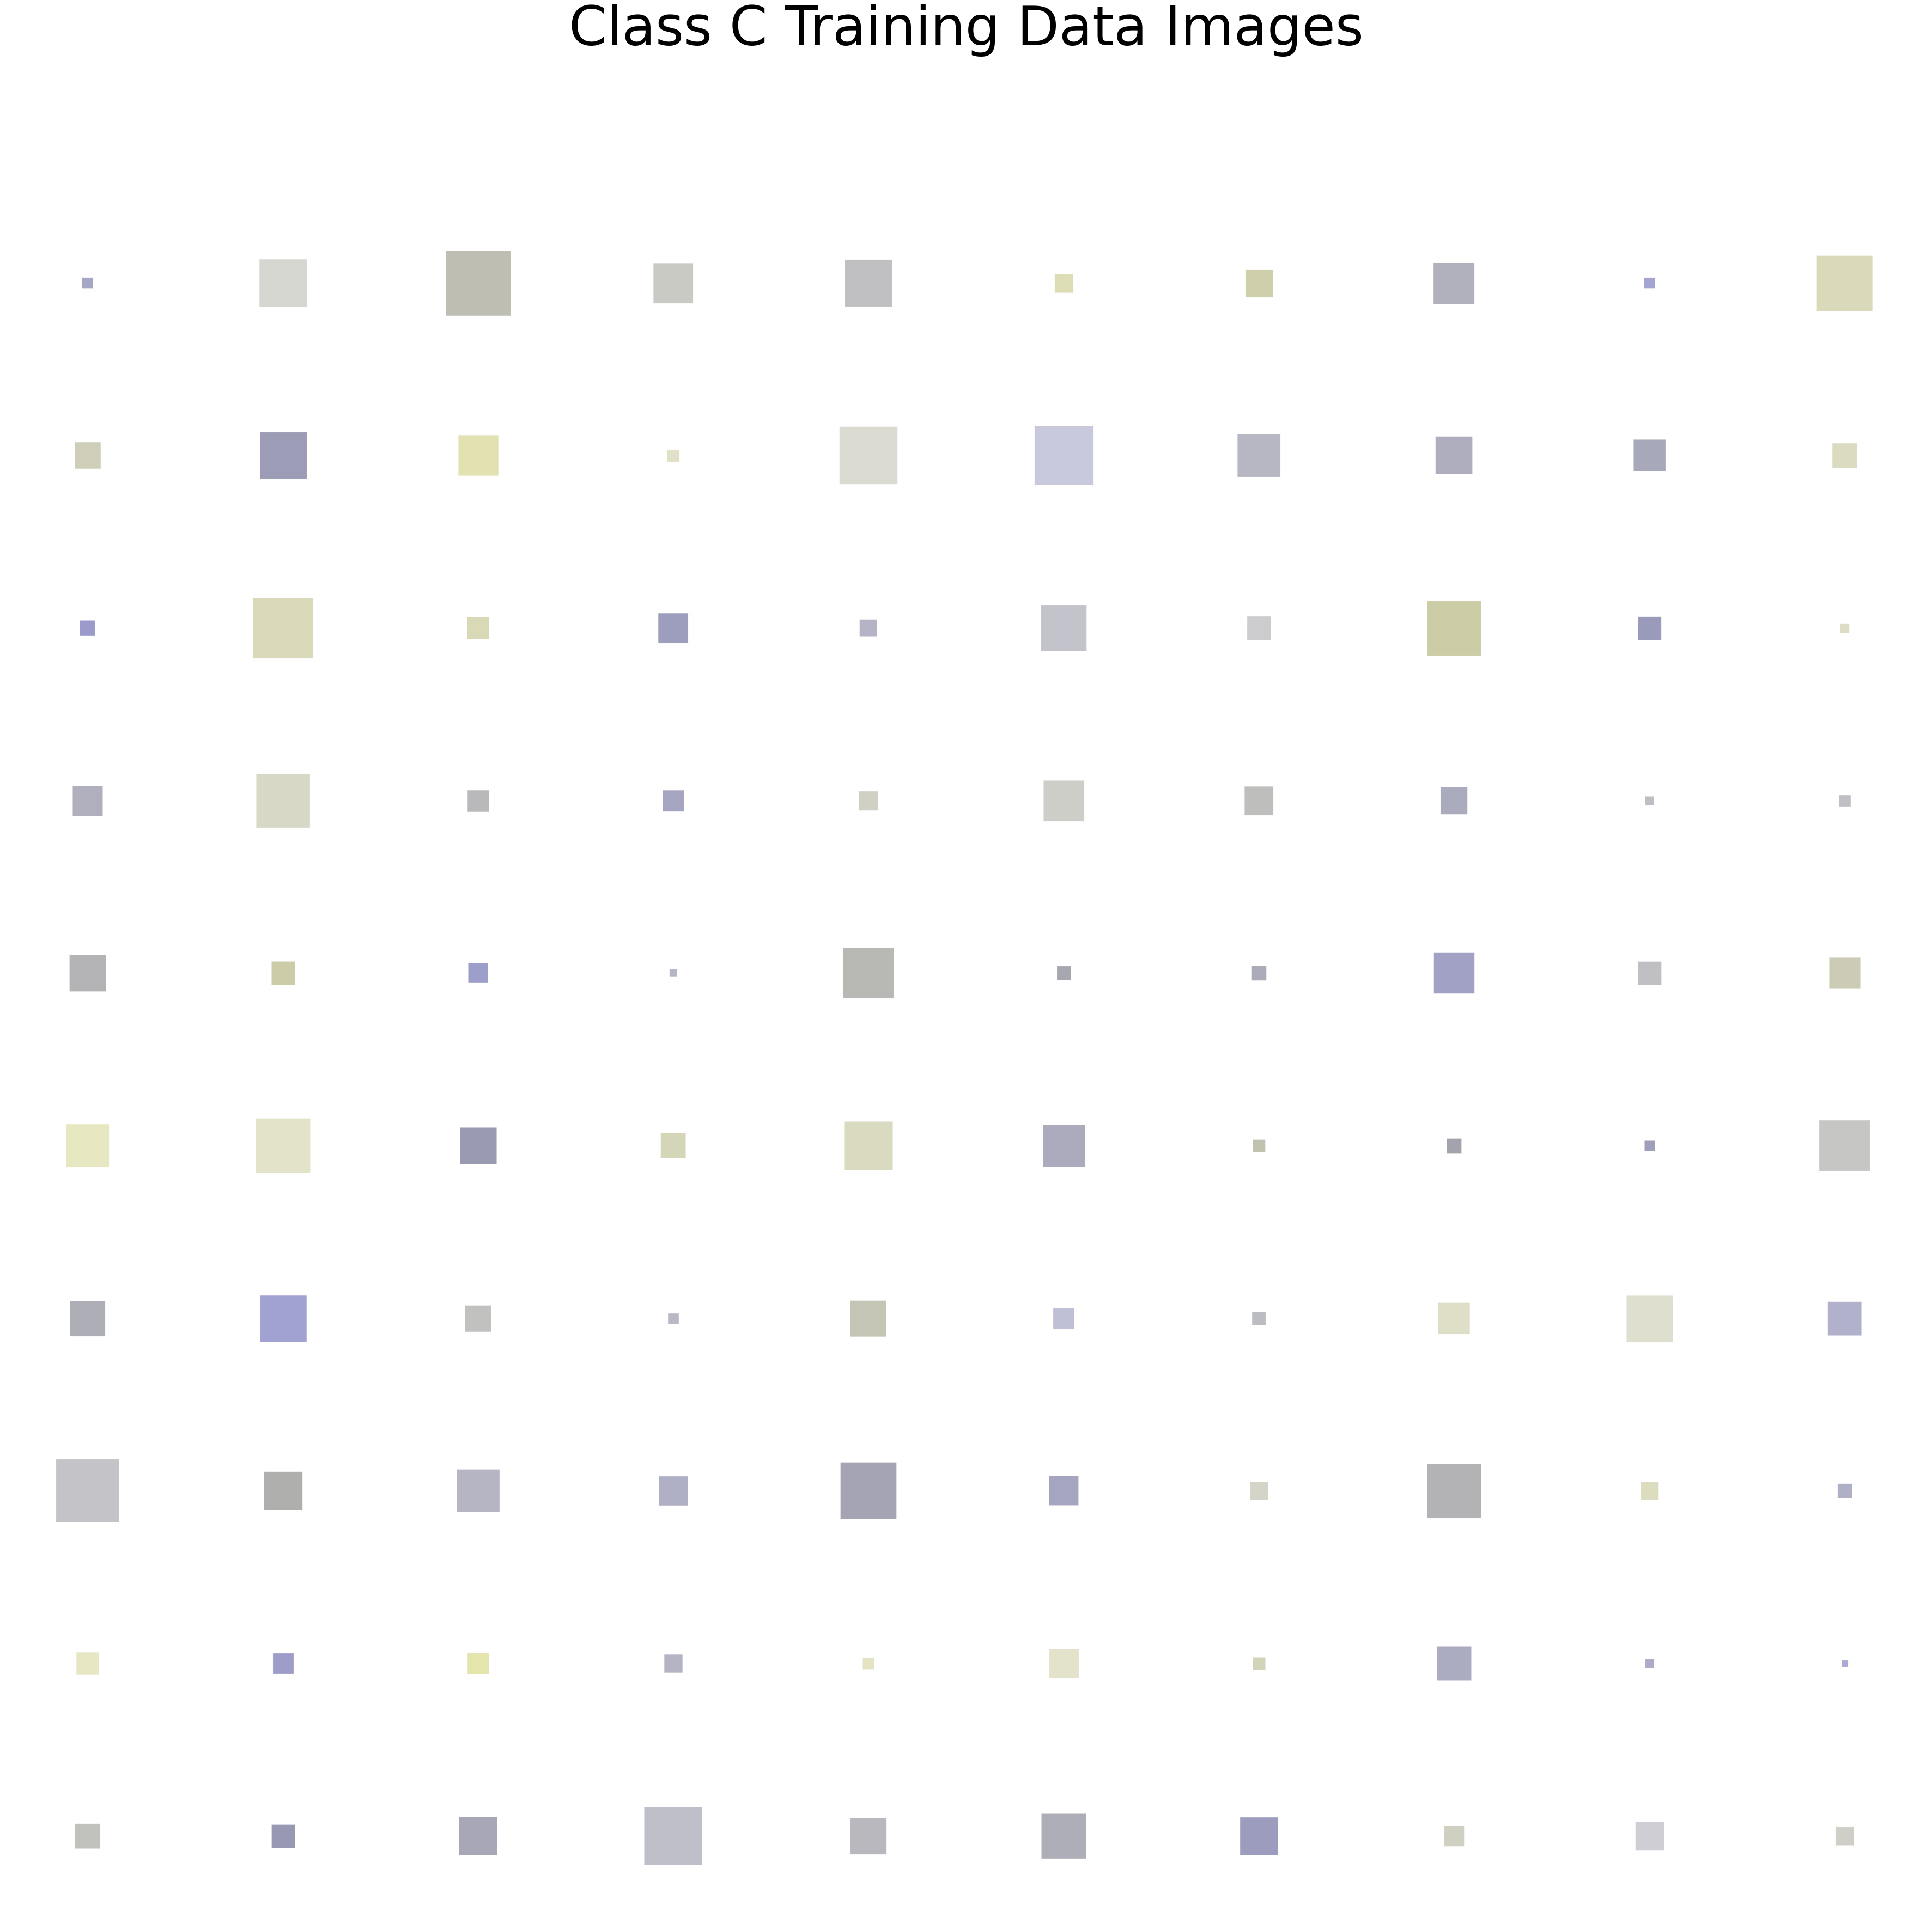

In [6]:
#Visualization of 100 random training images for each class

n_row = 10
n_col = 10

class_A = random.sample(class_a_train_images, 100)
class_B = random.sample(class_b_train_images, 100)
class_C = random.sample(class_c_train_images, 100)

fig, axs = plt.subplots(n_row, n_col, figsize=(50, 50))
fig.suptitle("Class A Training Data Images", fontsize=100)
axs = axs.flatten()
for img_path, ax in zip(class_A, axs):
    img = mpimg.imread(img_path)
    ax.axis("off")
    ax.imshow(img)
fig.tight_layout()
fig.subplots_adjust(top=0.88)
plt.show()

fig, axs = plt.subplots(n_row, n_col, figsize=(50, 50))
fig.suptitle("Class B Training Data Images", fontsize=100)
axs = axs.flatten()
for img_path, ax in zip(class_B, axs):
    img = mpimg.imread(img_path)
    ax.axis("off")
    ax.imshow(img)
fig.tight_layout()
fig.subplots_adjust(top=0.88)
plt.show()

fig, axs = plt.subplots(n_row, n_col, figsize=(50, 50))
fig.suptitle("Class C Training Data Images", fontsize=100)
axs = axs.flatten()
for img_path, ax in zip(class_C, axs):
    img = mpimg.imread(img_path)
    ax.axis("off")
    ax.imshow(img)
fig.tight_layout()
fig.subplots_adjust(top=0.88)
plt.show()

In [7]:
def get_square(img_path):
  '''
  Retain original squares
  Get rid of white background for generating image Statistics
  '''
  #Read Image
  image = cv2.imread(img_path)
  original = image.copy()
  #Convert to grayscale
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  #Threshold
  th, thresh = cv2.threshold(gray, 240, 255, cv2.THRESH_BINARY_INV)
  # Obtain bounding rectangle and extract ROI
  x,y,w,h = cv2.boundingRect(thresh)
  ROI = original[y:y+h, x:x+w]

  return ROI

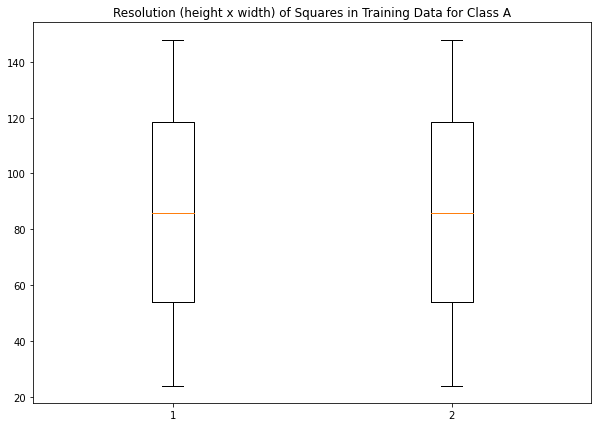

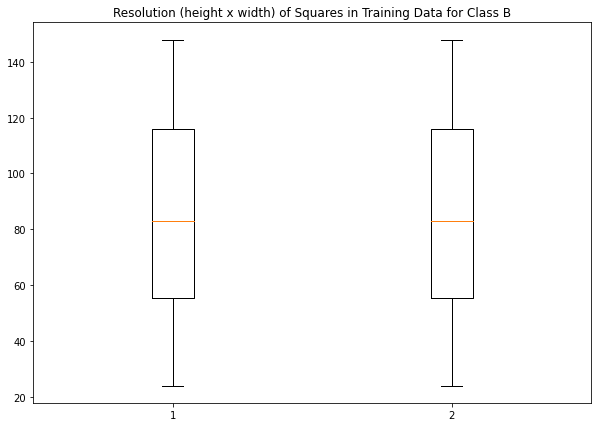

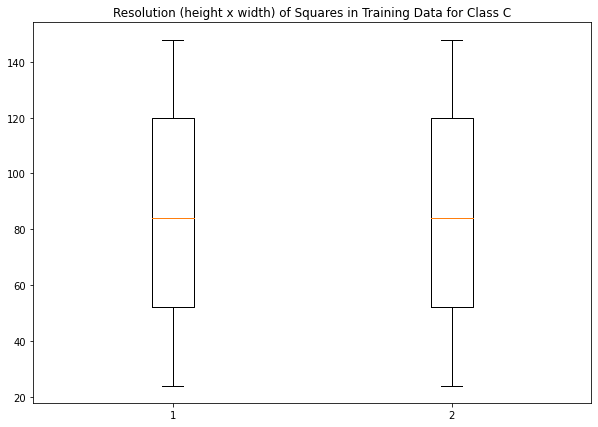

In [8]:
#Plot Resolutions for each class

def calculate_resolution(data_list):
  '''
  Calculate resolution of each square image
  '''
  resolution_per_class = list()
  for i in range(0,len(data_list)):
    img = get_square(data_list[i])
    resolution_per_class.append((img.shape[0],img.shape[1]))
    resolution_per_class_arr = np.array(resolution_per_class)
  return resolution_per_class_arr
    

resolution_a = calculate_resolution(class_a_train_images)
fig = plt.figure(figsize =(10, 7))
plt.boxplot(resolution_a)
plt.title('Resolution (height x width) of Squares in Training Data for Class A')
plt.show()

resolution_b = calculate_resolution(class_b_train_images)
fig = plt.figure(figsize =(10, 7))
plt.boxplot(resolution_b)
plt.title('Resolution (height x width) of Squares in Training Data for Class B')
plt.show()

resolution_c = calculate_resolution(class_c_train_images)
fig = plt.figure(figsize =(10, 7))
plt.boxplot(resolution_c)
plt.title('Resolution (height x width) of Squares in Training Data for Class C')
plt.show()

In [9]:
#Calculate Average Resolution
def calc_mean_resolution(resolution_list):
  sum = 0
  for sub in resolution_list:
      for i in sub:
          sum = sum + i
  res = sum / len(resolution_list)
  return res

print(f'Average Area of Class A {calc_mean_resolution(resolution_a)}')
print(f'Average Area of Class B {calc_mean_resolution(resolution_b)}')
print(f'Average Area of Class C {calc_mean_resolution(resolution_c)}')

Average Area of Class A 172.216
Average Area of Class B 169.208
Average Area of Class C 171.024


In [ ]:
def compute_luminosity(data_list):
  luminosity_min = list()
  luminosity_max = list()
  for i in range(0,len(data_list)):
    img = get_square(data_list[i])/255.0
    img_lab = rgb2lab(img)
    min_l = np.min(img_lab[:,:,0])
    max_l = np.max(img_lab[:,:,0])
    luminosity_min.append(min_l)
    luminosity_max.append(max_l)
  return luminosity_min, luminosity_max

l_a_min, l_a_max = compute_luminosity(class_a_train_images)
l_b_min, l_b_max = compute_luminosity(class_b_train_images)
l_c_min, l_c_max = compute_luminosity(class_c_train_images)

In [ ]:
print(f'Average Min Lightness for Class A Training Images {sum(l_a_min)/len(l_a_min)}')
print(f'Average Max Lightness for Class A Training Images {sum(l_a_max)/len(l_a_max)}')
print()
print(f'Average Min Lightness for Class B Training Images {sum(l_b_min)/len(l_b_min)}')
print(f'Average Max Lightness for Class B Training Images {sum(l_b_max)/len(l_b_max)}')
print()
print(f'Average Min Lightness for Class C Training Images {sum(l_c_min)/len(l_c_min)}')
print(f'Average Max Lightness for Class C Training Images {sum(l_c_max)/len(l_c_max)}')

Average Min Lightness for Class A Training Images 27.069019086437283
Average Max Lightness for Class A Training Images 28.194538753512415

Average Min Lightness for Class B Training Images 54.16588749074223
Average Max Lightness for Class B Training Images 55.43829635388294

Average Min Lightness for Class C Training Images 77.44490914275224
Average Max Lightness for Class C Training Images 78.33748738412602


In [ ]:
#Compute Laplacian Variance in Images
def compute_laplacian(data_list):
  laplacian_variance = list()
  for i in range(0,len(data_list)):
    img = get_square(data_list[i])
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    laplacian = cv2.Laplacian(gray, cv2.CV_64F)
    # get variances
    variance = np.var(laplacian)
    laplacian_variance.append(variance)
  return laplacian_variance

laplacian_variance_a = compute_laplacian(class_a_train_images)
laplacian_variance_b = compute_laplacian(class_b_train_images)
laplacian_variance_c = compute_laplacian(class_c_train_images)

print(f'Average value of image pixelation - Laplacian variance - Class A Images {sum(laplacian_variance_a)/len(laplacian_variance_a)}')
print(f'Average value of image pixelation - Laplacian variance - Class B Images {sum(laplacian_variance_b)/len(laplacian_variance_b)}')
print(f'Average value of image pixelation - Laplacian variance - Class C Images {sum(laplacian_variance_c)/len(laplacian_variance_c)}')

Average value of image pixelation - Laplacian variance - Class A Images 0.841073886408515
Average value of image pixelation - Laplacian variance - Class B Images 0.8420524009753639
Average value of image pixelation - Laplacian variance - Class C Images 0.6039285756833307


In [ ]:
def estimate_noise(I):
  H, W = I.shape
  M = [[1, -2, 1],
       [-2, 4, -2],
       [1, -2, 1]]
  sigma = np.sum(np.sum(np.absolute(signal.convolve2d(I, M))))
  sigma = sigma * math.sqrt(0.5 * math.pi) / (6 * (W-2) * (H-2))
  return sigma

def calculate_noise_variance(data_list):
  noise_variance = list()
  for i in range(0,len(data_list)):
    img = get_square(data_list[i])
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    sigma = estimate_noise(gray)
    noise_variance.append(sigma)
  return noise_variance

noise_variance_a = calculate_noise_variance(class_a_train_images)
noise_variance_b = calculate_noise_variance(class_b_train_images)
noise_variance_c = calculate_noise_variance(class_c_train_images)

print(f'Average value of noise variance - Class A Images {sum(noise_variance_a)/len(noise_variance_a)}')
print(f'Average value of noise variance - Class B Images {sum(noise_variance_b)/len(noise_variance_b)}')
print(f'Average value of noise variance - Class C Images {sum(noise_variance_c)/len(noise_variance_c)}')

Average value of noise variance - Class A Images 0.09243447478570564
Average value of noise variance - Class B Images 0.1623568996568956
Average value of noise variance - Class C Images 0.23217618986502148


# Deep Learning Model Experimentation

In [ ]:
#Initialize Data Dir
data_dir = '/content/squares/'

In [ ]:
def get_dataloaders(input_size, batch_size, shuffle = True):
    '''
    Build dataloaders with transformations. 

    Args:
        input_size: int, the size of the tranformed images
        batch_size: int, minibatch size for dataloading

    Returns:
        dataloader_dict: dict, dict with "train", "val", "test" keys, each is mapped to a pytorch dataloader.

    '''

    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]

    resized_transform = transforms.Resize((input_size,input_size))
    tensor_transform = transforms.ToTensor()
    normalized_transform = transforms.Normalize(mean, std)
    center_crop = transforms.CenterCrop(size=50)
    #Not sure if rotation invariance is expected / not
    angle = random.choice([90, 180, 360])
    rotater = transforms.RandomRotation(degrees=angle)

    composed_transform = transforms.Compose([resized_transform, tensor_transform, normalized_transform, center_crop])
    
    dataloaders_dict={}
    data_train= datasets.ImageFolder(root = data_dir + '/train', transform=composed_transform)
    data_test= datasets.ImageFolder(root = data_dir + '/test', transform=composed_transform)
    data_val= datasets.ImageFolder(root = data_dir + '/val', transform=composed_transform)

    dataloaders_dict['train'] = torch.utils.data.DataLoader(data_train, batch_size=batch_size, shuffle=True, num_workers=2)
    dataloaders_dict['test'] = torch.utils.data.DataLoader(data_test, batch_size=batch_size, shuffle=True, num_workers=2)
    dataloaders_dict['val'] = torch.utils.data.DataLoader(data_val, batch_size=batch_size, shuffle=True, num_workers=2)

    return dataloaders_dict

In [ ]:
#Test the dataloaders with arbitary batch-size , input-size
batch_size = 16
input_size = 224
dataloaders_dict = get_dataloaders(input_size, batch_size)

print('# of training samples {}'.format(len(dataloaders_dict['train'].dataset))) 
print('# of validation samples {}'.format(len(dataloaders_dict['val'].dataset)))
print('# of test samples {}'.format(len(dataloaders_dict['test'].dataset)))    

# of training samples 1500
# of validation samples 804
# of test samples 696


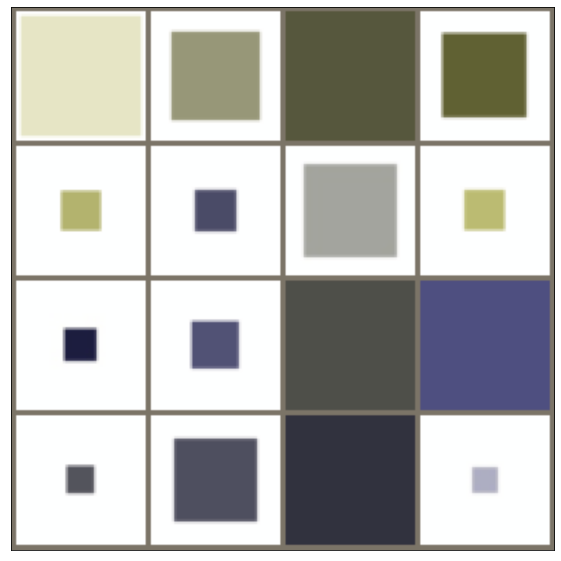

In [ ]:
# Visualize the data using dataloaders output
import json

def imshow(inp, title=None, ax=None, figsize=(5, 5)):
  """Imshow for Tensor."""
  inp = inp.numpy().transpose((1, 2, 0))
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  inp = std * inp + mean
  inp = np.clip(inp, 0, 1)
  if ax is None:
    fig, ax = plt.subplots(1, figsize=figsize)
  ax.imshow(inp)
  ax.set_xticks([])
  ax.set_yticks([])
  if title is not None:
    ax.set_title(title)
# Get a batch of training data
inputs, classes = next(iter(dataloaders_dict['train']))
# Make a grid from batch
out = torchvision.utils.make_grid(inputs, nrow=4)
fig, ax = plt.subplots(1, figsize=(10, 10))
imshow(out, ax=ax)

In [ ]:
#Helper Function to count parameters of model
def count_params(model):
    num_params = sum([item.numel() for item in model.parameters() if item.requires_grad])
    return num_params

# Optimizer and Loss Functions

In [ ]:
def make_optimizer(model):
    '''
    Args:
        model: NN to train

    Returns:
        optimizer: pytorch optmizer for updating the given model parameters.
    '''
    learning_rate = 1e-3
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    return optimizer

def get_loss():
    '''
    Returns:
        criterion: pytorch loss. 
    '''
    criterion=nn.CrossEntropyLoss()

    return criterion

# Training Loop

In [ ]:
def train_model(model, dataloaders, criterion, optimizer, save_dir = None, num_epochs=25, model_name='MiniVGG'):
    '''
    Args:
        model: The NN to train
        dataloaders: A dictionary containing at least the keys 
                    'train','val' that maps to Pytorch data loaders for the dataset
        criterion: The Loss function
        optimizer: Pytroch optimizer. The algorithm to update weights 
        num_epochs: How many epochs to train for
        save_dir: Where to save the best model weights that are found. Using None will not write anything to disk.

    Returns:
        model: The trained NN
        tr_acc_history: list, training accuracy history. Recording freq: one epoch.
        val_acc_history: list, validation accuracy history. Recording freq: one epoch.
    '''

    val_acc_history = []
    tr_acc_history = []

    val_loss_history = []
    tr_loss_history = []
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            # loss and number of correct prediction for the current batch
            running_loss = 0.0
            running_corrects = 0
            # Iterate over data.
            for inputs, labels in tqdm(dataloaders[phase]):
              inputs = inputs.to(device)
              labels = labels.to(device)
              out = model(inputs)
              loss = criterion(out, labels)
              preds = torch.argmax(out,dim=1)
              if phase == 'train':
                optimizer.zero_grad()
                loss.backward()
                optimizer.step() 
              # statistics
              running_loss += loss.item() * inputs.size(0)
              running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                if save_dir:
                    torch.save(best_model_wts, os.path.join(save_dir, model_name + '.pth'))
            # record the train/val accuracies
            if phase == 'val':
                val_acc_history.append(epoch_acc)
                val_loss_history.append(epoch_loss)
            else:
                tr_acc_history.append(epoch_acc)
                tr_loss_history.append(epoch_loss)

    print('Best val Acc: {:4f}'.format(best_acc))
    return model, tr_acc_history, val_acc_history, tr_loss_history, val_loss_history

In [ ]:
# Number of classes in the dataset
num_classes = 3
# Batch size for training 
batch_size = 128
# Shuffle the input data?
shuffle_datasets = True
# Number of epochs to train for
num_epochs = 25
# Directory to save weights to
save_dir = "weights"
os.makedirs(save_dir, exist_ok=True)

# get dataloders and criterion function
input_size = 224
dataloaders_data = get_dataloaders(input_size, batch_size, shuffle_datasets)
criterion = get_loss()

# Mini-VGG with Batch Normalization Network

In [ ]:
# "M" corresponds to maxpooling layer, integers correspond to number of output channels of a convolutional layer.
cfgs = {
    'MiniVGG-BN': [64, 'M', 128, 'M', 128, 'M']
}

def make_layers(cfg, batch_norm=False):

    '''
    Return a nn.Sequential object containing all layers before the fully-connected layers in the VGG11 network. 

    Args:
      cfg: list
      batch_norm: bool, default: False. If set to True, a BatchNorm layer should be added after each convolutional layer.

    Return:
      features: torch.nn.Sequential. Containers for all feature extraction layers. For use of torch.nn.Sequential, please refer to PyTorch documents.
    '''

    layer_list=[]
    channels = 3
    for m in cfg:
      if m == 'M': 
        layer_list = layer_list + [nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)]
      else:
        convolution2d = nn.Conv2d(channels, m, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        if batch_norm:
          layer_list= layer_list + [convolution2d, nn.BatchNorm2d(m, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), nn.ReLU(inplace=True)]
        else:
          layer_list= layer_list +  [convolution2d, nn.ReLU(inplace=True)]
        channels = m
    features= nn.Sequential(*layer_list)
    return features

class VGG(nn.Module):

    def __init__(self, features, num_classes=100, init_weights=True):
        super(VGG, self).__init__()

        self.features = features
        self.avgpool = nn.AdaptiveAvgPool2d((5, 5))
        self.classifier = nn.Sequential(nn.Linear(3200,512,bias=True), nn.ReLU(inplace=True), 
                                        nn.Dropout(0.3, inplace=False), nn.Linear(512,256,bias=True),
                                        nn.ReLU(inplace=True), nn.Dropout(p=0.3,inplace=False),
                                        nn.Linear(256,num_classes,bias=True))
        if init_weights:
            self._initialize_weights()

    def forward(self, x): 
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

    def _initialize_weights(self):
      for m in self.modules():
          if isinstance(m, nn.Conv2d):
              nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
              if m.bias is not None:
                  nn.init.constant_(m.bias, 0)
          elif isinstance(m, nn.BatchNorm2d):
              nn.init.constant_(m.weight, 1)
              nn.init.constant_(m.bias, 0)
          elif isinstance(m, nn.Linear):
              nn.init.normal_(m.weight, 0, 0.01)
              nn.init.constant_(m.bias, 0)

In [ ]:
features = make_layers(cfgs['MiniVGG-BN'], batch_norm=True)
vgg_bn = VGG(features)
print(vgg_bn)
print('Number of trainable parameters {}'.format(count_params(vgg_bn)))

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(5, 5))
  (classifier): Sequential(
    (0): Linear(in_features=3200, out_features=512, 

In [ ]:
# Initialize MiniVGG-BN
features = make_layers(cfgs['MiniVGG-BN'], batch_norm=True)
model = VGG(features).to(device)
optimizer = make_optimizer(model)
# Train the model!
vgg_BN, tr_acc_hist, val_acc_hist, tr_loss_hist, val_loss_hist = train_model(model=model, dataloaders=dataloaders_data, criterion=criterion, optimizer=optimizer, save_dir=save_dir, num_epochs=num_epochs, model_name='MiniVGG-BN')


Epoch 0/24
----------


100%|██████████| 12/12 [00:10<00:00,  1.12it/s]


train Loss: 1.7451 Acc: 0.4773


100%|██████████| 7/7 [00:02<00:00,  2.41it/s]


val Loss: 0.6839 Acc: 0.6716
Epoch 1/24
----------


100%|██████████| 12/12 [00:06<00:00,  1.81it/s]


train Loss: 0.1883 Acc: 0.9313


100%|██████████| 7/7 [00:02<00:00,  2.34it/s]


val Loss: 0.4264 Acc: 0.8657
Epoch 2/24
----------


100%|██████████| 12/12 [00:05<00:00,  2.19it/s]


train Loss: 0.0890 Acc: 0.9747


100%|██████████| 7/7 [00:03<00:00,  2.27it/s]


val Loss: 0.1466 Acc: 0.9453
Epoch 3/24
----------


100%|██████████| 12/12 [00:09<00:00,  1.30it/s]


train Loss: 0.1441 Acc: 0.9660


100%|██████████| 7/7 [00:03<00:00,  1.80it/s]


val Loss: 0.1873 Acc: 0.9614
Epoch 4/24
----------


100%|██████████| 12/12 [00:05<00:00,  2.21it/s]


train Loss: 0.0922 Acc: 0.9680


100%|██████████| 7/7 [00:03<00:00,  1.75it/s]


val Loss: 0.1495 Acc: 0.9552
Epoch 5/24
----------


100%|██████████| 12/12 [00:06<00:00,  1.80it/s]


train Loss: 0.0727 Acc: 0.9767


100%|██████████| 7/7 [00:03<00:00,  2.27it/s]


val Loss: 0.1082 Acc: 0.9552
Epoch 6/24
----------


100%|██████████| 12/12 [00:05<00:00,  2.20it/s]


train Loss: 0.0626 Acc: 0.9793


100%|██████████| 7/7 [00:02<00:00,  2.40it/s]


val Loss: 0.1115 Acc: 0.9789
Epoch 7/24
----------


100%|██████████| 12/12 [00:05<00:00,  2.22it/s]


train Loss: 0.0981 Acc: 0.9680


100%|██████████| 7/7 [00:02<00:00,  2.38it/s]


val Loss: 0.0996 Acc: 0.9801
Epoch 8/24
----------


100%|██████████| 12/12 [00:05<00:00,  2.26it/s]


train Loss: 0.1014 Acc: 0.9713


100%|██████████| 7/7 [00:03<00:00,  2.29it/s]


val Loss: 0.0557 Acc: 0.9801
Epoch 9/24
----------


100%|██████████| 12/12 [00:05<00:00,  2.18it/s]


train Loss: 0.0919 Acc: 0.9713


100%|██████████| 7/7 [00:02<00:00,  2.38it/s]


val Loss: 0.1174 Acc: 0.9602
Epoch 10/24
----------


100%|██████████| 12/12 [00:05<00:00,  2.20it/s]


train Loss: 0.0744 Acc: 0.9753


100%|██████████| 7/7 [00:02<00:00,  2.34it/s]


val Loss: 0.1160 Acc: 0.9726
Epoch 11/24
----------


100%|██████████| 12/12 [00:07<00:00,  1.59it/s]


train Loss: 0.0351 Acc: 0.9867


100%|██████████| 7/7 [00:02<00:00,  2.39it/s]


val Loss: 0.0683 Acc: 0.9813
Epoch 12/24
----------


100%|██████████| 12/12 [00:05<00:00,  2.18it/s]


train Loss: 0.0500 Acc: 0.9813


100%|██████████| 7/7 [00:03<00:00,  2.30it/s]


val Loss: 0.0728 Acc: 0.9813
Epoch 13/24
----------


100%|██████████| 12/12 [00:05<00:00,  2.25it/s]


train Loss: 0.0600 Acc: 0.9787


100%|██████████| 7/7 [00:02<00:00,  2.38it/s]


val Loss: 0.1044 Acc: 0.9764
Epoch 14/24
----------


100%|██████████| 12/12 [00:05<00:00,  2.24it/s]


train Loss: 0.0645 Acc: 0.9840


100%|██████████| 7/7 [00:02<00:00,  2.38it/s]


val Loss: 0.0689 Acc: 0.9813
Epoch 15/24
----------


100%|██████████| 12/12 [00:06<00:00,  1.90it/s]


train Loss: 0.0547 Acc: 0.9833


100%|██████████| 7/7 [00:02<00:00,  2.39it/s]


val Loss: 0.0507 Acc: 0.9826
Epoch 16/24
----------


100%|██████████| 12/12 [00:05<00:00,  2.15it/s]


train Loss: 0.0737 Acc: 0.9727


100%|██████████| 7/7 [00:03<00:00,  2.28it/s]


val Loss: 0.0580 Acc: 0.9801
Epoch 17/24
----------


100%|██████████| 12/12 [00:05<00:00,  2.24it/s]


train Loss: 0.0468 Acc: 0.9853


100%|██████████| 7/7 [00:02<00:00,  2.34it/s]


val Loss: 0.0998 Acc: 0.9776
Epoch 18/24
----------


100%|██████████| 12/12 [00:06<00:00,  1.96it/s]


train Loss: 0.0466 Acc: 0.9860


100%|██████████| 7/7 [00:02<00:00,  2.39it/s]


val Loss: 0.0639 Acc: 0.9826
Epoch 19/24
----------


100%|██████████| 12/12 [00:05<00:00,  2.21it/s]


train Loss: 0.0406 Acc: 0.9847


100%|██████████| 7/7 [00:02<00:00,  2.36it/s]


val Loss: 0.0789 Acc: 0.9776
Epoch 20/24
----------


100%|██████████| 12/12 [00:05<00:00,  2.21it/s]


train Loss: 0.0476 Acc: 0.9807


100%|██████████| 7/7 [00:02<00:00,  2.37it/s]


val Loss: 0.0716 Acc: 0.9789
Epoch 21/24
----------


100%|██████████| 12/12 [00:05<00:00,  2.25it/s]


train Loss: 0.0666 Acc: 0.9740


100%|██████████| 7/7 [00:02<00:00,  2.41it/s]


val Loss: 0.0510 Acc: 0.9813
Epoch 22/24
----------


100%|██████████| 12/12 [00:05<00:00,  2.24it/s]


train Loss: 0.0782 Acc: 0.9747


100%|██████████| 7/7 [00:03<00:00,  2.26it/s]


val Loss: 0.0785 Acc: 0.9751
Epoch 23/24
----------


100%|██████████| 12/12 [00:05<00:00,  2.19it/s]


train Loss: 0.0414 Acc: 0.9867


100%|██████████| 7/7 [00:03<00:00,  2.30it/s]


val Loss: 0.0634 Acc: 0.9813
Epoch 24/24
----------


100%|██████████| 12/12 [00:05<00:00,  2.22it/s]


train Loss: 0.0373 Acc: 0.9847


100%|██████████| 7/7 [00:02<00:00,  2.37it/s]

val Loss: 0.0605 Acc: 0.9813
Best val Acc: 0.982587


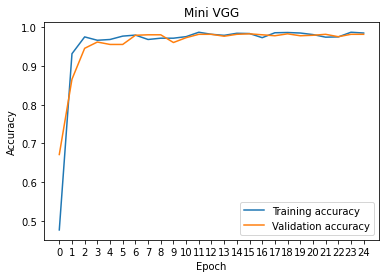

In [ ]:
tr_acc_hist_numpy = [a.cpu().numpy() for a in tr_acc_hist]
val_acc_hist_numpy = [a.cpu().numpy() for a in val_acc_hist]

# visualize the training / validation accuracies
x = np.arange(num_epochs)
plt.figure()
# train/val accuracies for MiniVGG-BN
plt.plot(x, tr_acc_hist_numpy)
plt.plot(x, val_acc_hist_numpy)
plt.legend(['Training accuracy', 'Validation accuracy'])
plt.xticks(x)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Mini VGG')
plt.show()

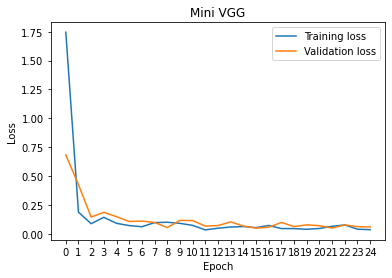

In [ ]:
# visualize the training / validation losses

x = np.arange(num_epochs)
plt.figure()
# train/val losses for MiniVGG-BN
plt.plot(x, tr_loss_hist)
plt.plot(x, val_loss_hist)
plt.legend(['Training loss', 'Validation loss'])
plt.xticks(x)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Mini VGG')
plt.show()

# RESNET18 - Pretrained

In [ ]:
#Transfer Learning
model_ft = models.resnet18(pretrained=True)
for param in model_ft.parameters():
    param.requires_grad = False
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 3)
model_ft = model_ft.to(device)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [ ]:
optimizer = make_optimizer(model_ft)

# Train the model!
resnet_18, tr_acc_hist, val_acc_hist, tr_loss_hist, val_loss_hist = train_model(model=model_ft, dataloaders=dataloaders_data, criterion=criterion, optimizer=optimizer,
           save_dir=save_dir, num_epochs=num_epochs, model_name='RESNET18')

Epoch 0/24
----------


100%|██████████| 12/12 [00:05<00:00,  2.25it/s]


train Loss: 1.0167 Acc: 0.5200


100%|██████████| 7/7 [00:03<00:00,  2.24it/s]


val Loss: 1.0246 Acc: 0.4664
Epoch 1/24
----------


100%|██████████| 12/12 [00:05<00:00,  2.26it/s]


train Loss: 0.6107 Acc: 0.7713


100%|██████████| 7/7 [00:02<00:00,  2.34it/s]


val Loss: 0.6547 Acc: 0.7550
Epoch 2/24
----------


100%|██████████| 12/12 [00:05<00:00,  2.26it/s]


train Loss: 0.4699 Acc: 0.8180


100%|██████████| 7/7 [00:02<00:00,  2.35it/s]


val Loss: 0.4523 Acc: 0.8396
Epoch 3/24
----------


100%|██████████| 12/12 [00:05<00:00,  2.25it/s]


train Loss: 0.3890 Acc: 0.8673


100%|██████████| 7/7 [00:02<00:00,  2.37it/s]


val Loss: 0.3596 Acc: 0.8744
Epoch 4/24
----------


100%|██████████| 12/12 [00:05<00:00,  2.26it/s]


train Loss: 0.3411 Acc: 0.8867


100%|██████████| 7/7 [00:03<00:00,  2.33it/s]


val Loss: 0.3250 Acc: 0.8968
Epoch 5/24
----------


100%|██████████| 12/12 [00:05<00:00,  2.26it/s]


train Loss: 0.3030 Acc: 0.8987


100%|██████████| 7/7 [00:02<00:00,  2.34it/s]


val Loss: 0.2977 Acc: 0.8993
Epoch 6/24
----------


100%|██████████| 12/12 [00:05<00:00,  2.26it/s]


train Loss: 0.2908 Acc: 0.9020


100%|██████████| 7/7 [00:02<00:00,  2.37it/s]


val Loss: 0.2826 Acc: 0.9092
Epoch 7/24
----------


100%|██████████| 12/12 [00:05<00:00,  2.28it/s]


train Loss: 0.2833 Acc: 0.9007


100%|██████████| 7/7 [00:02<00:00,  2.39it/s]


val Loss: 0.2686 Acc: 0.9067
Epoch 8/24
----------


100%|██████████| 12/12 [00:05<00:00,  2.21it/s]


train Loss: 0.2704 Acc: 0.9053


100%|██████████| 7/7 [00:02<00:00,  2.37it/s]


val Loss: 0.2521 Acc: 0.9216
Epoch 9/24
----------


100%|██████████| 12/12 [00:05<00:00,  2.28it/s]


train Loss: 0.2400 Acc: 0.9287


100%|██████████| 7/7 [00:02<00:00,  2.39it/s]


val Loss: 0.2466 Acc: 0.9254
Epoch 10/24
----------


100%|██████████| 12/12 [00:05<00:00,  2.28it/s]


train Loss: 0.2316 Acc: 0.9280


100%|██████████| 7/7 [00:02<00:00,  2.38it/s]


val Loss: 0.2350 Acc: 0.9279
Epoch 11/24
----------


100%|██████████| 12/12 [00:05<00:00,  2.29it/s]


train Loss: 0.2074 Acc: 0.9407


100%|██████████| 7/7 [00:03<00:00,  2.18it/s]


val Loss: 0.2341 Acc: 0.9266
Epoch 12/24
----------


100%|██████████| 12/12 [00:05<00:00,  2.26it/s]


train Loss: 0.1957 Acc: 0.9420


100%|██████████| 7/7 [00:02<00:00,  2.39it/s]


val Loss: 0.2270 Acc: 0.9279
Epoch 13/24
----------


100%|██████████| 12/12 [00:05<00:00,  2.25it/s]


train Loss: 0.1917 Acc: 0.9407


100%|██████████| 7/7 [00:02<00:00,  2.39it/s]


val Loss: 0.2198 Acc: 0.9391
Epoch 14/24
----------


100%|██████████| 12/12 [00:05<00:00,  2.27it/s]


train Loss: 0.1836 Acc: 0.9460


100%|██████████| 7/7 [00:02<00:00,  2.36it/s]


val Loss: 0.2100 Acc: 0.9366
Epoch 15/24
----------


100%|██████████| 12/12 [00:05<00:00,  2.25it/s]


train Loss: 0.1788 Acc: 0.9487


100%|██████████| 7/7 [00:02<00:00,  2.37it/s]


val Loss: 0.2115 Acc: 0.9328
Epoch 16/24
----------


100%|██████████| 12/12 [00:05<00:00,  2.22it/s]


train Loss: 0.1808 Acc: 0.9487


100%|██████████| 7/7 [00:02<00:00,  2.34it/s]


val Loss: 0.2082 Acc: 0.9328
Epoch 17/24
----------


100%|██████████| 12/12 [00:05<00:00,  2.28it/s]


train Loss: 0.1723 Acc: 0.9473


100%|██████████| 7/7 [00:02<00:00,  2.35it/s]


val Loss: 0.2042 Acc: 0.9353
Epoch 18/24
----------


100%|██████████| 12/12 [00:05<00:00,  2.28it/s]


train Loss: 0.1580 Acc: 0.9567


100%|██████████| 7/7 [00:02<00:00,  2.37it/s]


val Loss: 0.1987 Acc: 0.9415
Epoch 19/24
----------


100%|██████████| 12/12 [00:05<00:00,  2.22it/s]


train Loss: 0.1572 Acc: 0.9487


100%|██████████| 7/7 [00:02<00:00,  2.36it/s]


val Loss: 0.1944 Acc: 0.9403
Epoch 20/24
----------


100%|██████████| 12/12 [00:05<00:00,  2.27it/s]


train Loss: 0.1505 Acc: 0.9580


100%|██████████| 7/7 [00:02<00:00,  2.36it/s]


val Loss: 0.1947 Acc: 0.9428
Epoch 21/24
----------


100%|██████████| 12/12 [00:05<00:00,  2.27it/s]


train Loss: 0.1434 Acc: 0.9640


100%|██████████| 7/7 [00:02<00:00,  2.37it/s]


val Loss: 0.1946 Acc: 0.9366
Epoch 22/24
----------


100%|██████████| 12/12 [00:05<00:00,  2.28it/s]


train Loss: 0.1522 Acc: 0.9560


100%|██████████| 7/7 [00:03<00:00,  2.17it/s]


val Loss: 0.1892 Acc: 0.9391
Epoch 23/24
----------


100%|██████████| 12/12 [00:05<00:00,  2.26it/s]


train Loss: 0.1493 Acc: 0.9533


100%|██████████| 7/7 [00:02<00:00,  2.37it/s]


val Loss: 0.2005 Acc: 0.9353
Epoch 24/24
----------


100%|██████████| 12/12 [00:05<00:00,  2.26it/s]


train Loss: 0.1414 Acc: 0.9553


100%|██████████| 7/7 [00:02<00:00,  2.35it/s]

val Loss: 0.1873 Acc: 0.9415
Best val Acc: 0.942786


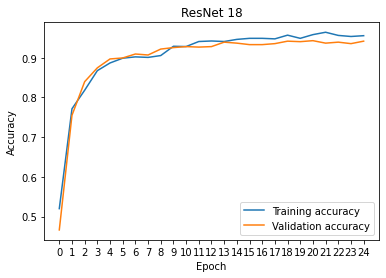

In [ ]:
tr_acc_hist_numpy = [a.cpu().numpy() for a in tr_acc_hist]
val_acc_hist_numpy = [a.cpu().numpy() for a in val_acc_hist]

# visualize the training / validation accuracies
x = np.arange(num_epochs)
plt.figure()
plt.plot(x, tr_acc_hist_numpy)
plt.plot(x, val_acc_hist_numpy)
plt.legend(['Training accuracy', 'Validation accuracy'])
plt.xticks(x)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('ResNet 18')
plt.show()

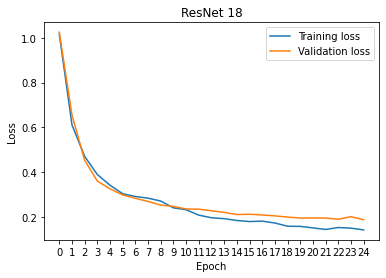

In [ ]:
# visualize the training / validation losses

x = np.arange(num_epochs)
plt.figure()
plt.plot(x, tr_loss_hist)
plt.plot(x, val_loss_hist)
plt.legend(['Training loss', 'Validation loss'])
plt.xticks(x)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('ResNet 18')
plt.show()

## Test on Test Data

In [ ]:
def test(model, dataloader):
    '''
    Calculate the accuracy of the trained classifier on the test set.
    '''
    model.eval()

    y_pred = []
    y_true = []

    loss_epoch = 0
    corrects_epoch = 0
    phase= 'test'
    for x, y in dataloader[phase]:
      x, y = x.to(device), y.to(device)
      outs = model(x)
      preds = torch.argmax(outs, dim=1)
      y_pred.extend(preds.cpu().numpy())
      y_true.extend(y.cpu().numpy())
      
      corrects_epoch += torch.sum(preds == y.data)

    epoch_acc = corrects_epoch.double() / len(dataloader[phase].dataset)
    print('Test accuracy {}'.format(epoch_acc))
    return y_pred, y_true

In [ ]:
print('Accuracy of Test Data on VGG Network')
vgg_pred, vgg_true = test(vgg_BN,dataloaders_data)

print('Accuracy of Test Data on ResNet18 Network')
resnet_pred, resnet_true = test(resnet_18, dataloaders_data)

Accuracy of Test Data on VGG Network
Test accuracy 0.9813218390804598
Accuracy of Test Data on ResNet18 Network
Test accuracy 0.9454022988505747


In [ ]:
def build_confusion_matrix(y_pred, y_true, plot_title=''):
  classes = ('a', 'b', 'c')

  # Build confusion matrix
  cf_matrix = confusion_matrix(y_true, y_pred)
  df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1), index = [i for i in classes],
                      columns = [i for i in classes])
  plt.figure(figsize = (12,7))
  plt.title(plot_title)
  sn.heatmap(df_cm, annot=True)

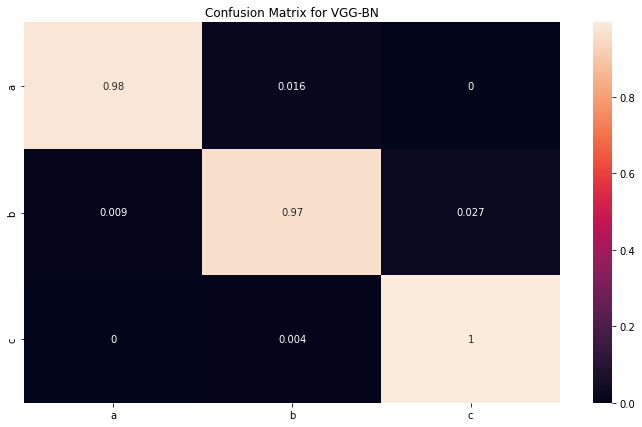

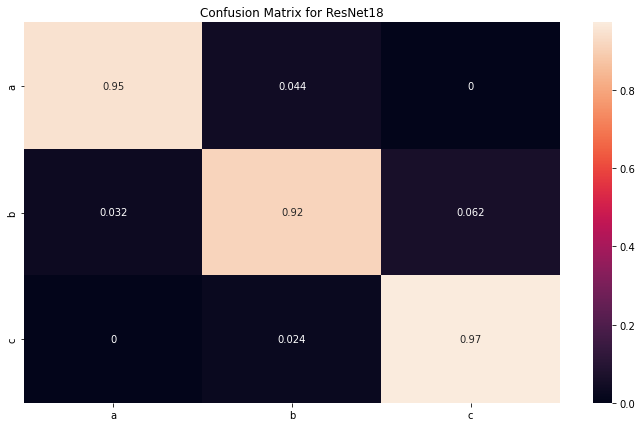

In [ ]:
build_confusion_matrix(vgg_pred, vgg_true, plot_title='Confusion Matrix for VGG-BN')
build_confusion_matrix(resnet_pred, resnet_true, plot_title='Confusion Matrix for ResNet18')